In [1]:
#import all necessary packages
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import plot, show
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

%matplotlib inline

In [2]:
#Reading the csv files
df1=pd.read_csv('./bank-additional/bank-additional-full.csv',sep=';')
df2=pd.read_csv('./bank-additional/bank-additional.csv',sep=';')
data=pd.concat([df1,df2])
data0=data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45307 entries, 0 to 4118
Data columns (total 21 columns):
age               45307 non-null int64
job               45307 non-null object
marital           45307 non-null object
education         45307 non-null object
default           45307 non-null object
housing           45307 non-null object
loan              45307 non-null object
contact           45307 non-null object
month             45307 non-null object
day_of_week       45307 non-null object
duration          45307 non-null int64
campaign          45307 non-null int64
pdays             45307 non-null int64
previous          45307 non-null int64
poutcome          45307 non-null object
emp.var.rate      45307 non-null float64
cons.price.idx    45307 non-null float64
cons.conf.idx     45307 non-null float64
euribor3m         45307 non-null float64
nr.employed       45307 non-null float64
y                 45307 non-null object
dtypes: float64(5), int64(5), object(11)
memory usag

In [4]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000,45307.000000
mean,40.032203,258.148917,2.564835,962.288785,0.174543,0.082166,93.576032,-40.502282,3.621297,5166.985525
std,10.411407,258.864200,2.752261,187.370863,0.499364,1.570231,0.578881,4.625101,1.734350,72.380791
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### We see that the column 'duration' seems skewed.  Also the range of 'nr.employed' is quite off scales for other columns. 

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


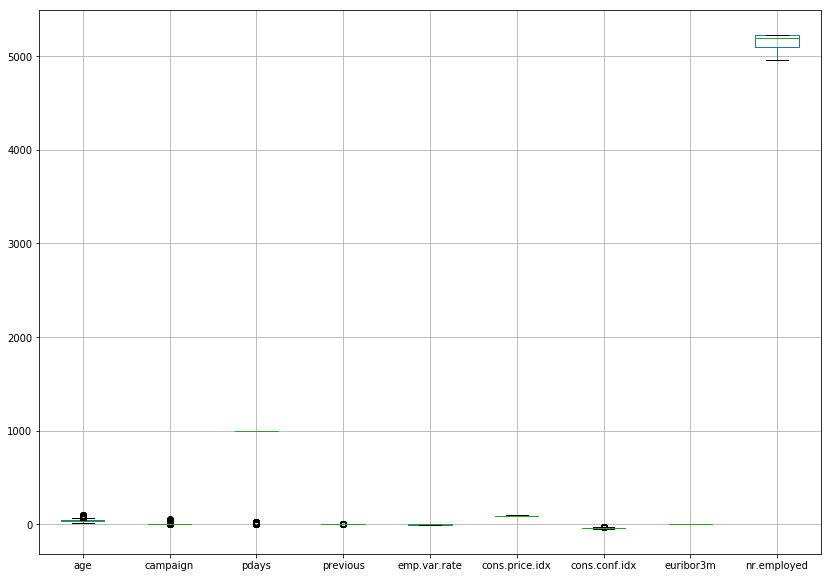

In [5]:
quant=data[['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']]
fig = plt.figure(figsize=(14, 10))
print(quant.columns)
quant.boxplot()
#plt.set_title('Default', fontsize=10)
plt.show()

In [6]:
data['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

### We see that job contains some unknown data so we need to check if response is independent on the unknown values of the job. Therefore the job can be grouped into known and unknown categories. Then they will be tested using the contigency table

In [7]:
job_known = data[data['job']!='unknown']
job_known_yes = job_known[job_known['y']=='yes'].y.value_counts().sum()
job_known_no = job_known[job_known['y']=='no'].y.value_counts().sum()

job_unknown = data[data['job']=='unknown']
job_unknown_yes = job_unknown[job_unknown['y']=='yes'].y.value_counts().sum()
job_unknown_no = job_unknown[job_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[job_known_no, job_known_yes], [job_unknown_no, job_unknown_yes]])
print(obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

[[39888  5050]
 [  328    41]]


(3.68403648211336e-05,
 0.9951571685287003,
 1,
 array([[39888.46332796,  5049.53667204],
        [  327.53667204,    41.46332796]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 0.9952 meaning H0 hypothesis(independence) can be accepted, i.e., the unknown status (missing data for job) does not impact the outcome of response. The missing of job data is randomly missed and therefore we may delete those missing data. There are 369 missing data for job need to be removed.

In [8]:
data = data[data['job']!='unknown']
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44938 entries, 0 to 4118
Data columns (total 21 columns):
age               44938 non-null int64
job               44938 non-null object
marital           44938 non-null object
education         44938 non-null object
default           44938 non-null object
housing           44938 non-null object
loan              44938 non-null object
contact           44938 non-null object
month             44938 non-null object
day_of_week       44938 non-null object
duration          44938 non-null int64
campaign          44938 non-null int64
pdays             44938 non-null int64
previous          44938 non-null int64
poutcome          44938 non-null object
emp.var.rate      44938 non-null float64
cons.price.idx    44938 non-null float64
cons.conf.idx     44938 non-null float64
euribor3m         44938 non-null float64
nr.employed       44938 non-null float64
y                 44938 non-null object
dtypes: float64(5), int64(5), object(11)
memory usag

In [9]:
data['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [10]:
marital_known = data[data['marital']!='unknown']
marital_known_yes = marital_known[marital_known['y']=='yes'].y.value_counts().sum()
marital_known_no = marital_known[marital_known['y']=='no'].y.value_counts().sum()

marital_unknown = data[data['marital']=='unknown']
marital_unknown_yes = marital_unknown[marital_unknown['y']=='yes'].y.value_counts().sum()
marital_unknown_no = marital_unknown[marital_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[marital_known_no, marital_known_yes], [marital_unknown_no, marital_unknown_yes]])
print(obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

[[39816  5040]
 [   72    10]]


(0.00995432388975868,
 0.9205258475181421,
 1,
 array([[3.98152149e+04, 5.04078508e+03],
        [7.27850817e+01, 9.21491833e+00]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 0.9205 meaning H0 hypothesis(independence) can be accepted, i.e., the unknown status (missing data for marital) does not impact the outcome of response. The missing of marital data is randomly missed and therefore we may delete those missing data. There are 82 missing data for marital status need to be removed.

In [11]:
data = data[data['marital']!='unknown']
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44856 entries, 0 to 4118
Data columns (total 21 columns):
age               44856 non-null int64
job               44856 non-null object
marital           44856 non-null object
education         44856 non-null object
default           44856 non-null object
housing           44856 non-null object
loan              44856 non-null object
contact           44856 non-null object
month             44856 non-null object
day_of_week       44856 non-null object
duration          44856 non-null int64
campaign          44856 non-null int64
pdays             44856 non-null int64
previous          44856 non-null int64
poutcome          44856 non-null object
emp.var.rate      44856 non-null float64
cons.price.idx    44856 non-null float64
cons.conf.idx     44856 non-null float64
euribor3m         44856 non-null float64
nr.employed       44856 non-null float64
y                 44856 non-null object
dtypes: float64(5), int64(5), object(11)
memory usag

In [12]:
data['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [13]:
education_known = data[data['education']!='unknown']
education_known_yes = education_known[education_known['y']=='yes'].y.value_counts().sum()
education_known_no = education_known[education_known['y']=='no'].y.value_counts().sum()

education_unknown = data[data['education']=='unknown']
education_unknown_yes = education_unknown[education_unknown['y']=='yes'].y.value_counts().sum()
education_unknown_no = education_unknown[education_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[education_known_no, education_known_yes], [education_unknown_no, education_unknown_yes]])
print(obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

[[38324  4782]
 [ 1492   258]]


(22.091007266749553,
 2.600250136648344e-06,
 1,
 array([[38262.62921348,  4843.37078652],
        [ 1553.37078652,   196.62921348]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 2.600 e -6 meaning H0 hypothesis(independence) cannot be accepted, i.e., the unknown status (missing data for education) impacts the outcome of response. Therefore we are to keep the missing data for education and use them as new category.

In [14]:
data['default'].unique()

array(['no', 'unknown', 'yes'], dtype=object)

In [15]:
default_known = data[data['default']!='unknown']
default_known_yes = default_known[default_known['y']=='yes'].y.value_counts().sum()
default_known_no = default_known[default_known['y']=='no'].y.value_counts().sum()

default_unknown = data[data['default']=='unknown']
default_unknown_yes = default_unknown[default_unknown['y']=='yes'].y.value_counts().sum()
default_unknown_no = default_unknown[default_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[default_known_no, default_known_yes], [default_unknown_no, default_unknown_yes]])
print(obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

[[31080  4556]
 [ 8736   484]]


(416.26877966907807,
 1.5834305941574436e-92,
 1,
 array([[31631.95505618,  4004.04494382],
        [ 8184.04494382,  1035.95505618]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 1.583 e -92 meaning H0 hypothesis(independence) cannot be accepted, i.e., the unknown status (missing data for default) impacts the outcome of response. Therefore we are to keep the missing data for default and use them as new category.

In [16]:
data['housing'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [17]:
housing_known = data[data['housing']!='unknown']
housing_known_yes = housing_known[housing_known['y']=='yes'].y.value_counts().sum()
housing_known_no = housing_known[housing_known['y']=='no'].y.value_counts().sum()

housing_unknown = data[data['housing']=='unknown']
housing_unknown_yes = housing_unknown[housing_unknown['y']=='yes'].y.value_counts().sum()
housing_unknown_no = housing_unknown[housing_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[housing_known_no, housing_known_yes], [housing_unknown_no, housing_unknown_yes]])
print(obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

[[38843  4924]
 [  973   116]]


(0.32398687623786254,
 0.5692214719819244,
 1,
 array([[38849.35955056,  4917.64044944],
        [  966.64044944,   122.35955056]]))

### The Chi-square test for 2 x 2 contignency table indicates that p value = 0.5692 meaning H0 hypothesis(independence) can be accepted, i.e., the unknown status (missing data for housing) doe not impact the outcome of response.

In [18]:
data['loan'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [19]:
loan_known = data[data['loan']!='unknown']
loan_known_yes = loan_known[loan_known['y']=='yes'].y.value_counts().sum()
loan_known_no = loan_known[loan_known['y']=='no'].y.value_counts().sum()

loan_unknown = data[data['loan']=='unknown']
loan_unknown_yes = loan_unknown[loan_unknown['y']=='yes'].y.value_counts().sum()
loan_unknown_no = loan_unknown[loan_unknown['y']=='no'].y.value_counts().sum()

obs = np.array([[loan_known_no, loan_known_yes], [loan_unknown_no, loan_unknown_yes]])
print(obs)
stats.chi2_contingency(obs)
# output are the t-test statistic, p value and the expected values as 2 x 2 array

[[38843  4924]
 [  973   116]]


(0.32398687623786254,
 0.5692214719819244,
 1,
 array([[38849.35955056,  4917.64044944],
        [  966.64044944,   122.35955056]]))

In [20]:
y_yes = data[data['y']=='yes']['y'].value_counts().sum()
y_no = data[data['y']=='no']['y'].value_counts().sum()
yes_pct = y_yes /(y_yes+y_no)
print(yes_pct)

0.11235955056179775


  ### We can see from calculation that the percentage of making deposits is about 11.2% of all subjects. The goal of this project is to predict the chance of people making deposit and the dataset makes imbalanced in term of this goal. Therefore it is feasible to either reduce the portion of non-making deposits or increase the portion of making depostis.

## Explanatory data analysis (EDA)

### It is reasonable to divide ages into groups such as Young, Middle age and senior to study impact on the deposits

In [21]:
#group age into three categories: 17-35 young, 36-55 middle age, and 56+ senior
bins = [17, 35, 55, 100]
labels = ['young', 'middle-age', 'senior']
data['agerange'] = pd.cut(data.age, bins, labels = labels,include_lowest = True)

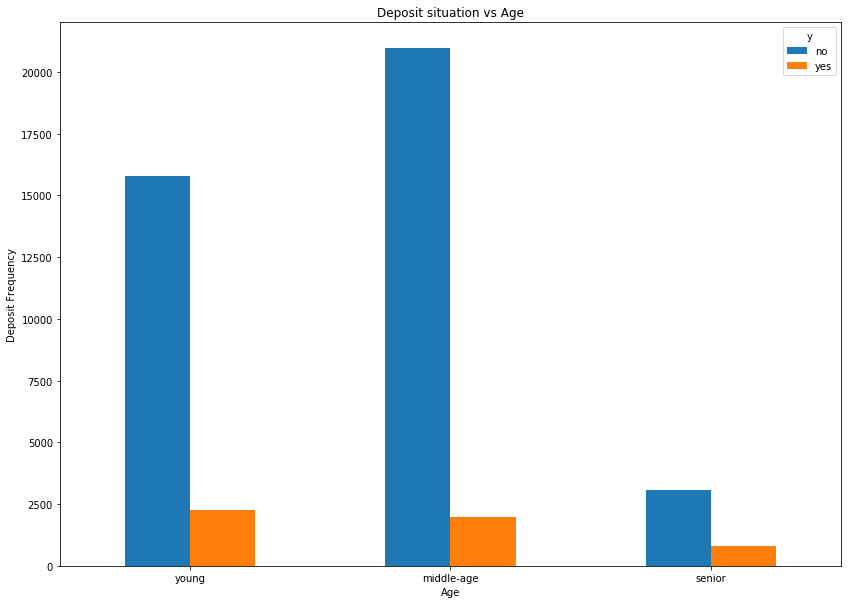

In [22]:
pd.crosstab(data['agerange'],data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs Age')
plt.xlabel('Age')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_age')

### It can been seen that more fraction of senior made deposits but young and middle aged take more percentage.  

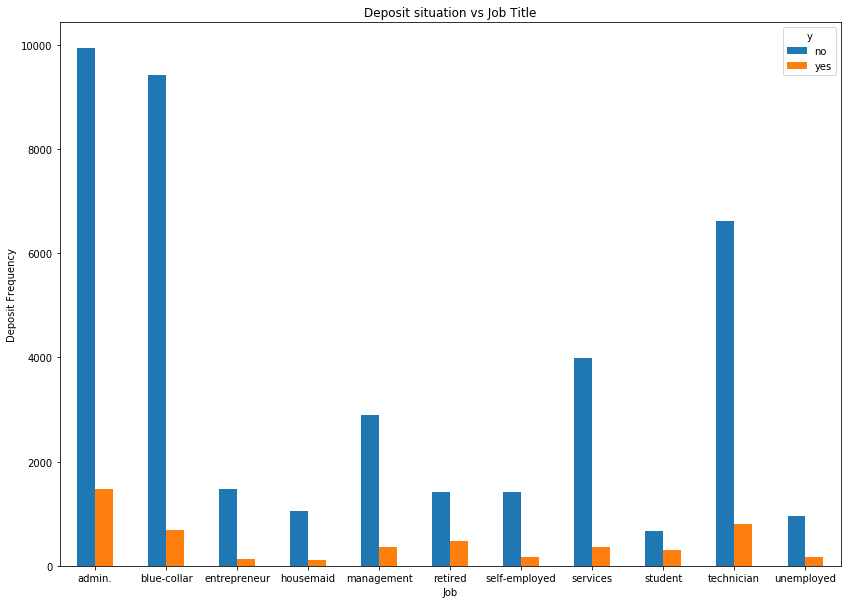

In [23]:
pd.crosstab(data.job,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs Job Title')
plt.xlabel('Job')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_job')

### It seems that the situation of  making deposits among all employment status correlate to the employment. 

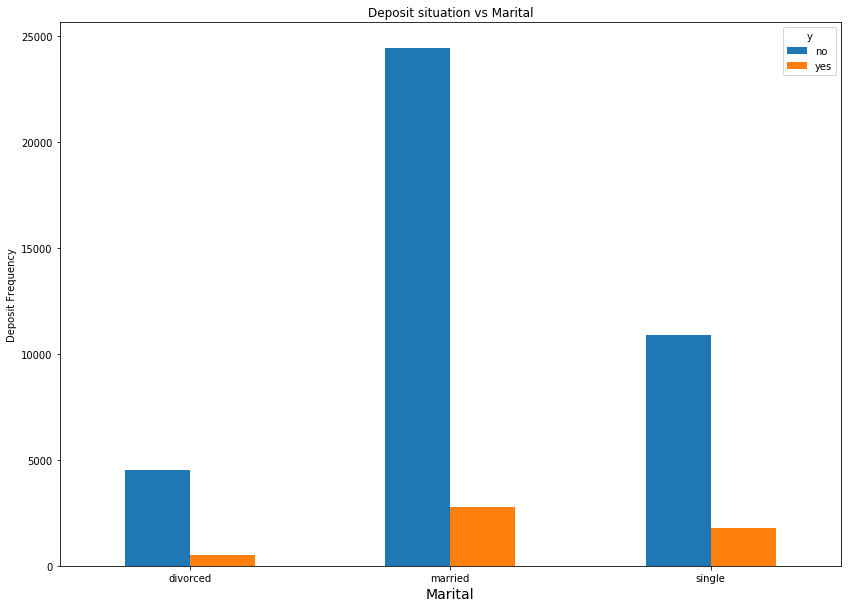

In [24]:
pd.crosstab(data.marital,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs Marital')
plt.xlabel('Marital',fontsize=14,rotation=0)
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_Marital')

### It seems that the marital status does not affect the deposit. About 10% all marital status made deposits.

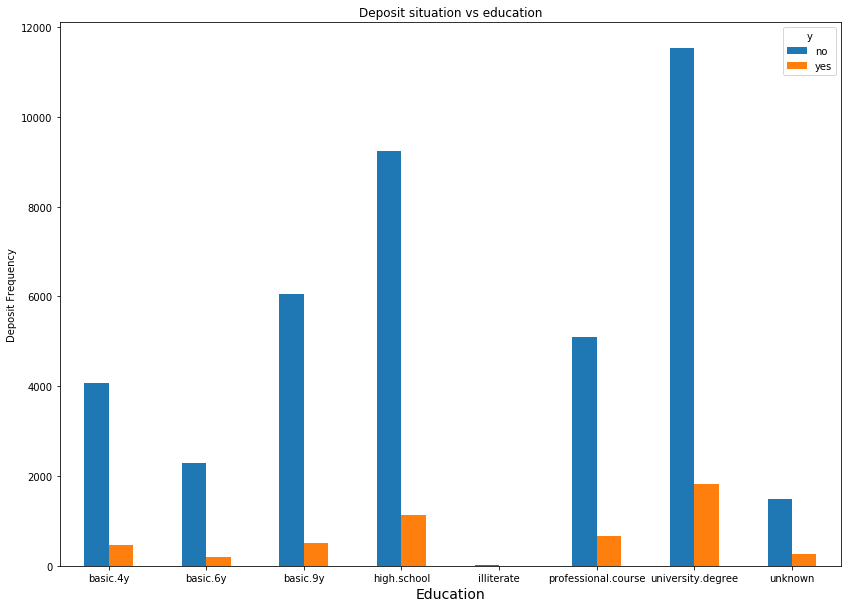

In [25]:
pd.crosstab(data.education,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs education')
plt.xlabel('Education',fontsize=14,rotation=0)
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_education')

### 14% of university degree holder made deposits and this group makes the majority of all people of interest. It seems that those having more education made more deposits

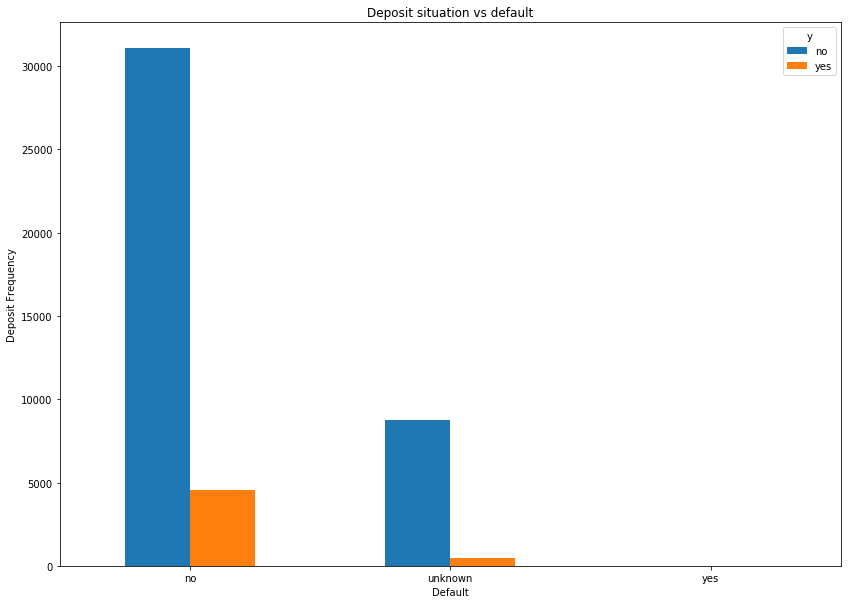

In [26]:
pd.crosstab(data.default,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs default')
plt.xlabel('Default')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_default')

### It seems that the default status doe not impact deposit since most of people do not default and about 13% of them made deposits.

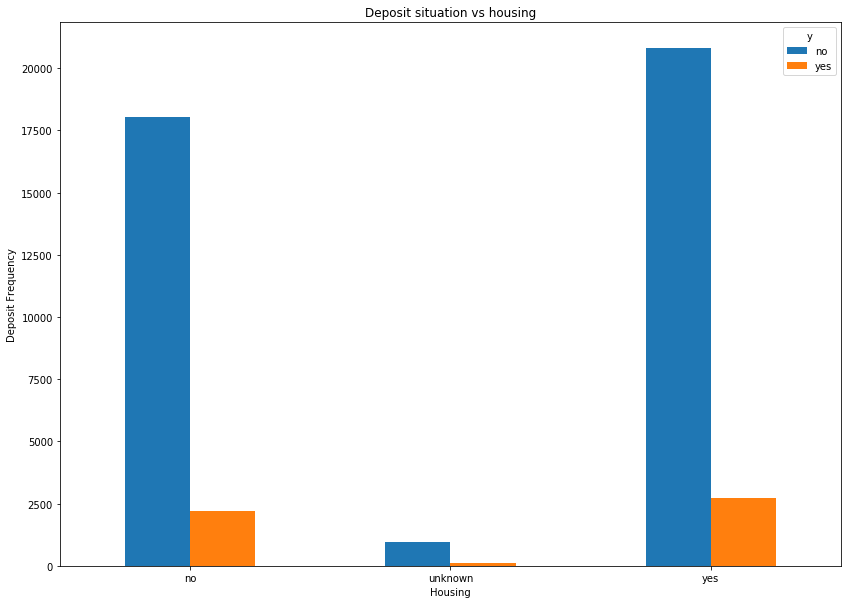

In [27]:
pd.crosstab(data.housing,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs housing')
plt.xlabel('Housing')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_housing')

### It is obvious that the housing status does not impact the deposits. 

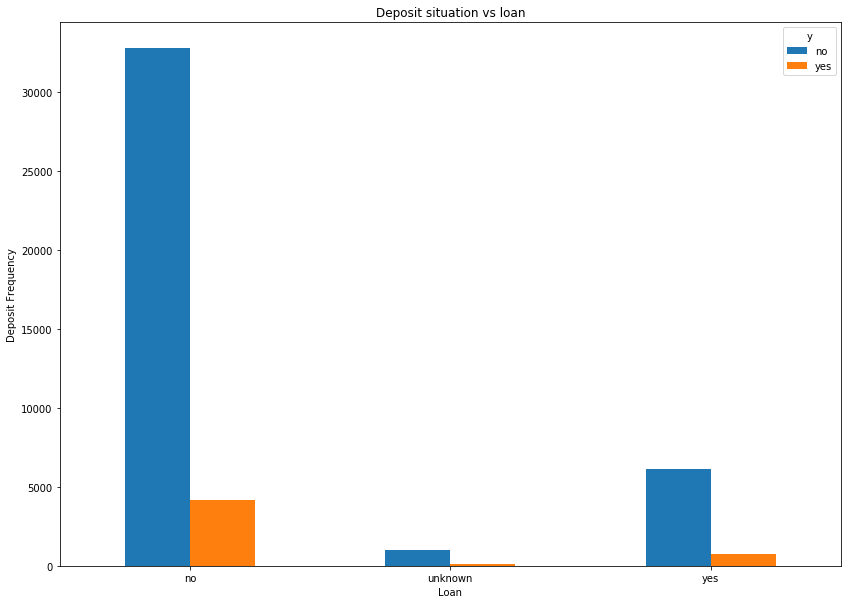

In [28]:
pd.crosstab(data.loan,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs loan')
plt.xlabel('Loan')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_loan')

### It is obvious that the loan does not affect the deposits.

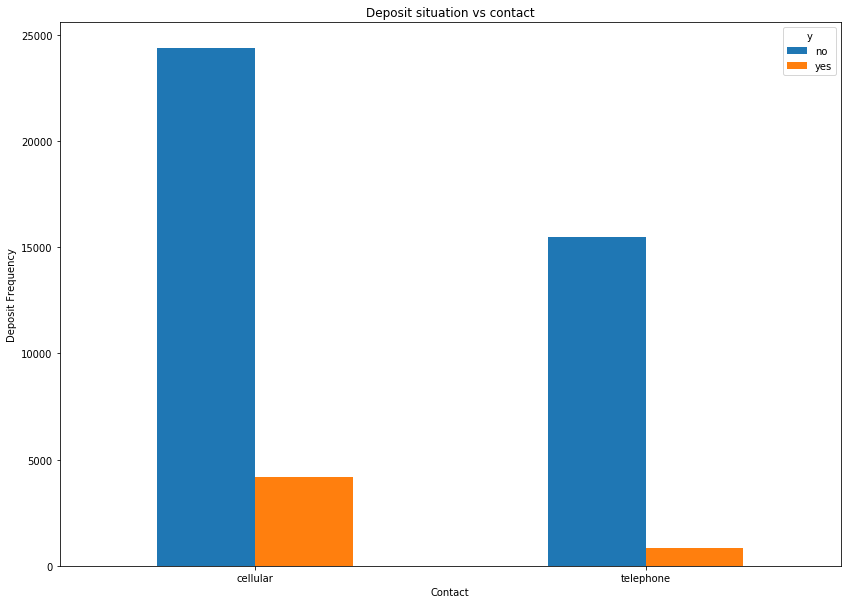

In [29]:
pd.crosstab(data.contact,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs contact')
plt.xlabel('Contact')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_contact')

### It indicates that more people are using cell phone than regular phones. Meanwhile about 15% cell phone users made deposits

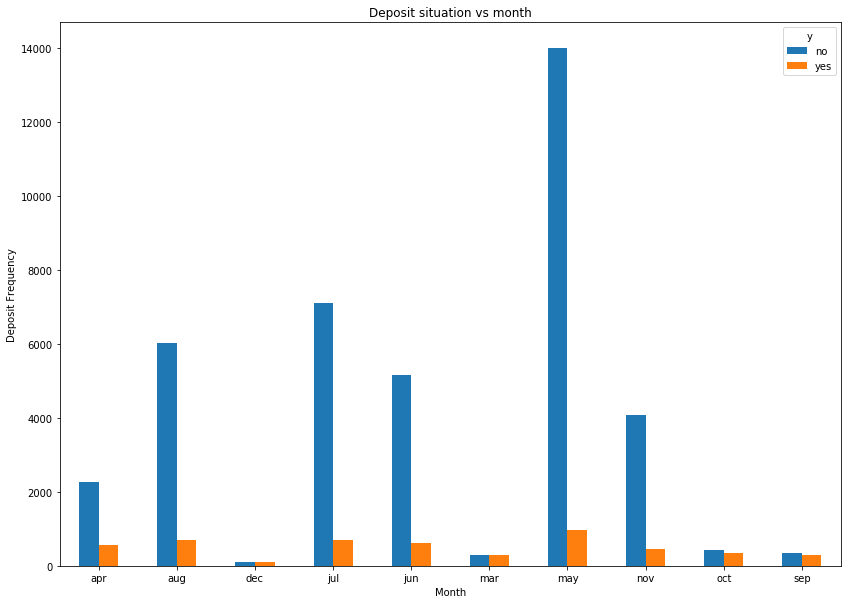

In [30]:
pd.crosstab(data.month,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs month')
plt.xlabel('Month')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_month')

### It is shown that in May and July when most of people surveyed about 10% people made deposits. In December, the lowest number of people surveyed this may due to the holiday season when there is no business running therefore the survey activities are not run.

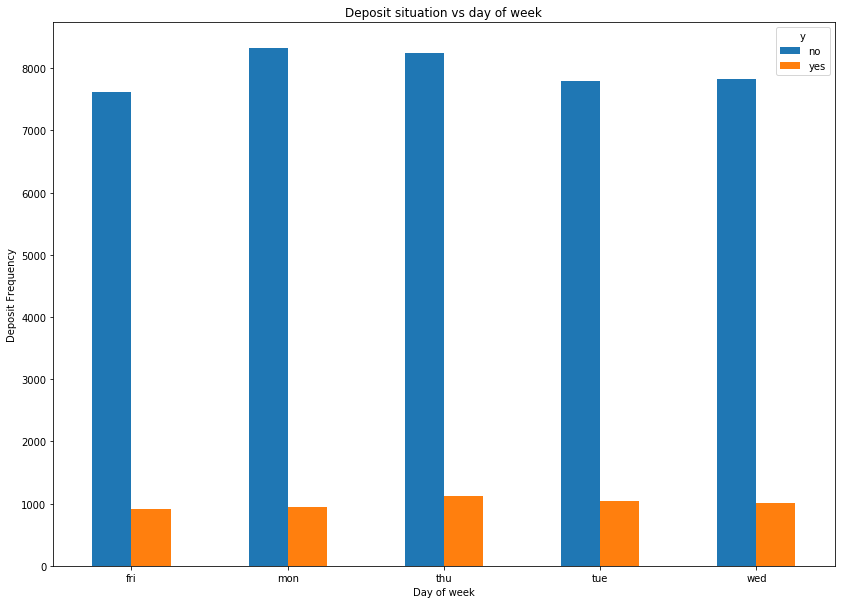

In [31]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs day of week')
plt.xlabel('Day of week')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_day')

### There is no dependence of day of week on the deposits and all weekdays about 11% people made deposits

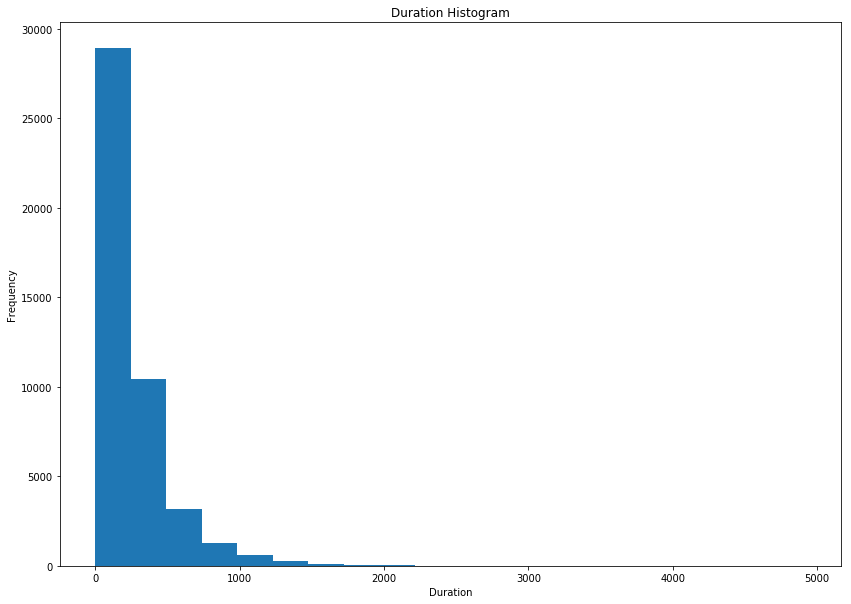

In [32]:
fig = plt.figure(figsize=(14, 10))
plt.hist(data['duration'],bins=20)
plt.title("Duration Histogram")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.savefig('Duration histogram')

In [33]:
#group duration into three categories: 0-102 short, 103-319 medium, and 320+ long
bins = [0, 102, 319, 4918]
labels = ['short', 'medium', 'long']
data['durationrange'] = pd.cut(data.duration, bins, labels = labels,include_lowest = True)

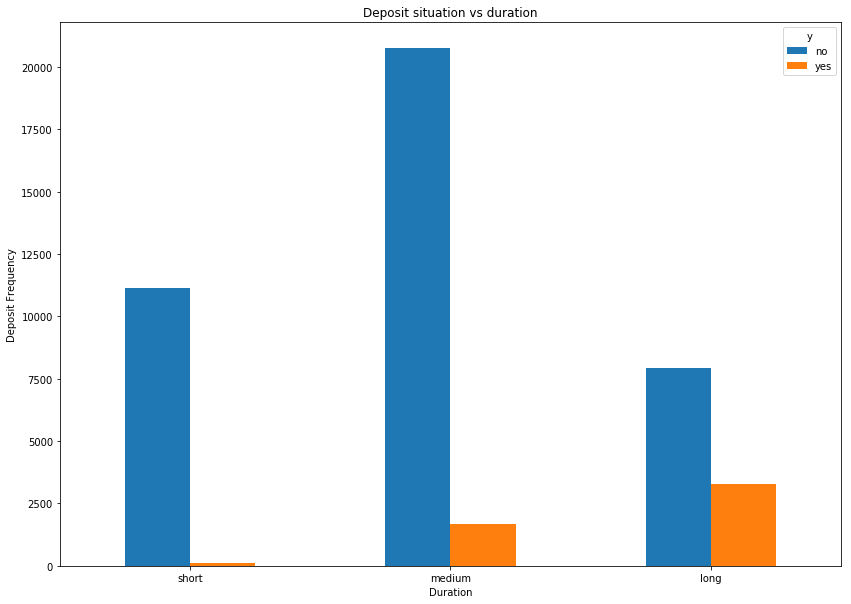

In [34]:
pd.crosstab(data.durationrange,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs duration')
plt.xlabel('Duration')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_duration')

### The relationship between duration and deposits: longer the duration, more fractions people made deposits.

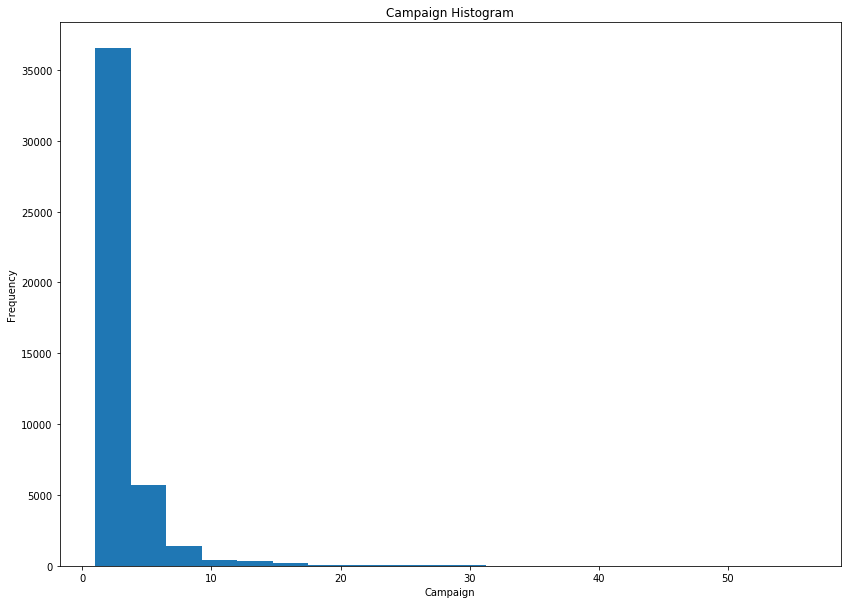

In [35]:
fig = plt.figure(figsize=(14, 10))
plt.hist(data['campaign'],bins=20)
plt.title("Campaign Histogram")
plt.xlabel("Campaign")
plt.ylabel("Frequency")
plt.savefig('Campaign histogram')

In [36]:
#group campaign into three categories: 0-1 small, 2-5 medium, and 6+ large
bins = [0, 1, 5, 56]
labels = ['small', 'medium', 'large']
data['campaignrange'] = pd.cut(data.campaign, bins, labels = labels,include_lowest = True)

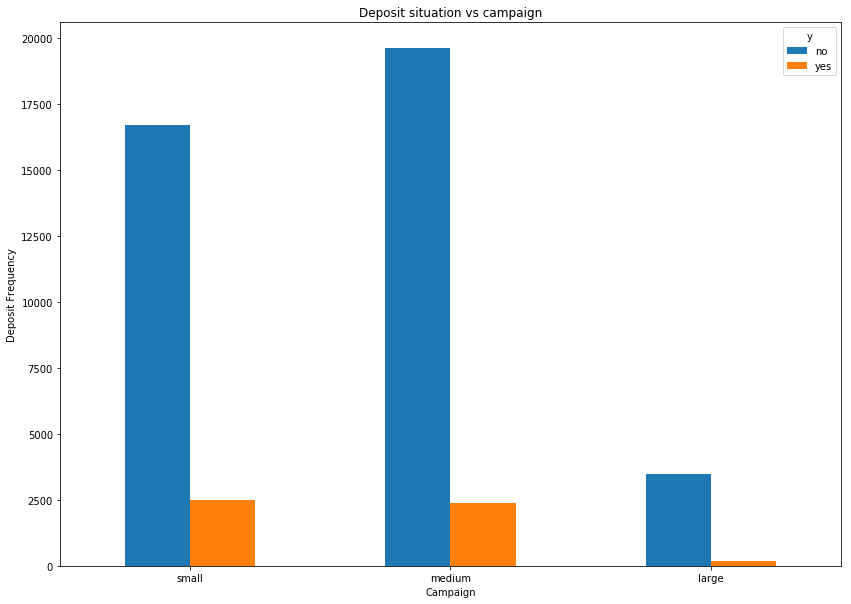

In [37]:
pd.crosstab(data.campaignrange,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs campaign')
plt.xlabel('Campaign')
plt.xticks(rotation = 0)
plt.ylabel('Deposit Frequency')
plt.savefig('Deposit_campaign')

### It shows that the bigger of the size of the campaign, less people made deposits.

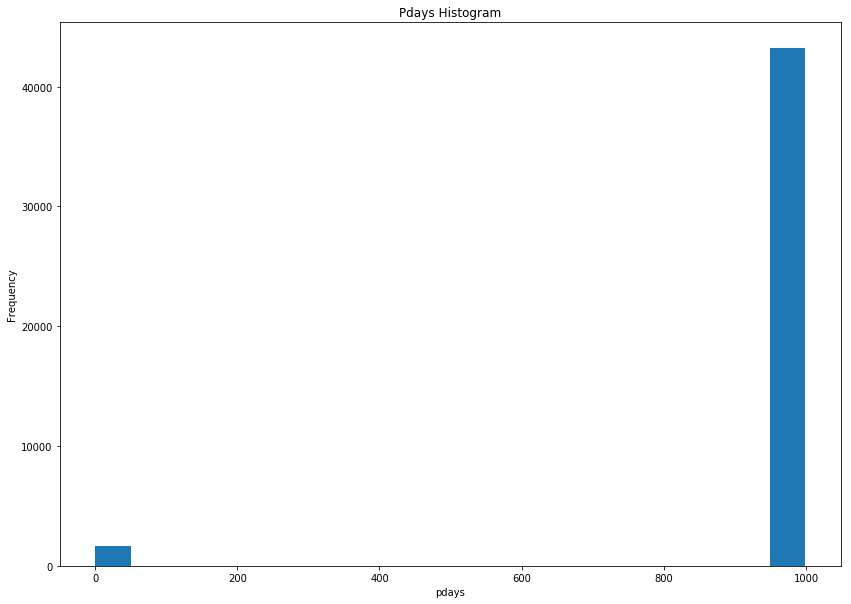

In [38]:
# pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['pdays'],bins=20)
plt.title("Pdays Histogram")
plt.xlabel("pdays")
plt.ylabel("Frequency")
plt.savefig('Pdays histogram')

In [39]:
#group pdays into three categories: 0-6 short, 7-21 medium, 22-27 long, and 28-999 never
bins = [0, 6, 21, 27, 999]
labels = ['short', 'medium', 'long','never']
data['pdaysrange'] = pd.cut(data.pdays, bins, labels = labels,include_lowest = True)

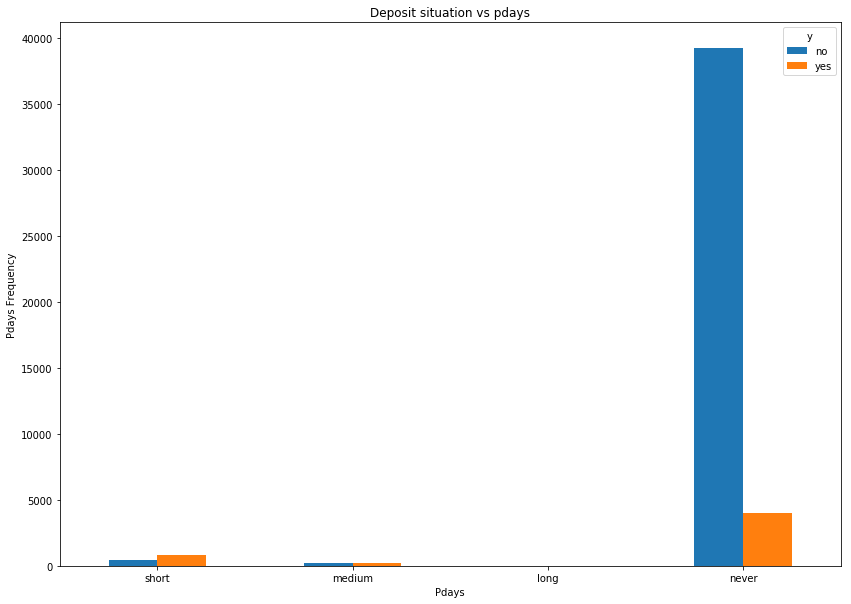

In [40]:
pd.crosstab(data.pdaysrange,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs pdays')
plt.xlabel('Pdays')
plt.xticks(rotation = 0)
plt.ylabel('Pdays Frequency')
plt.savefig('Deposit_pdays')

### It can be seen that shorter the pdays,  more people made deposits.

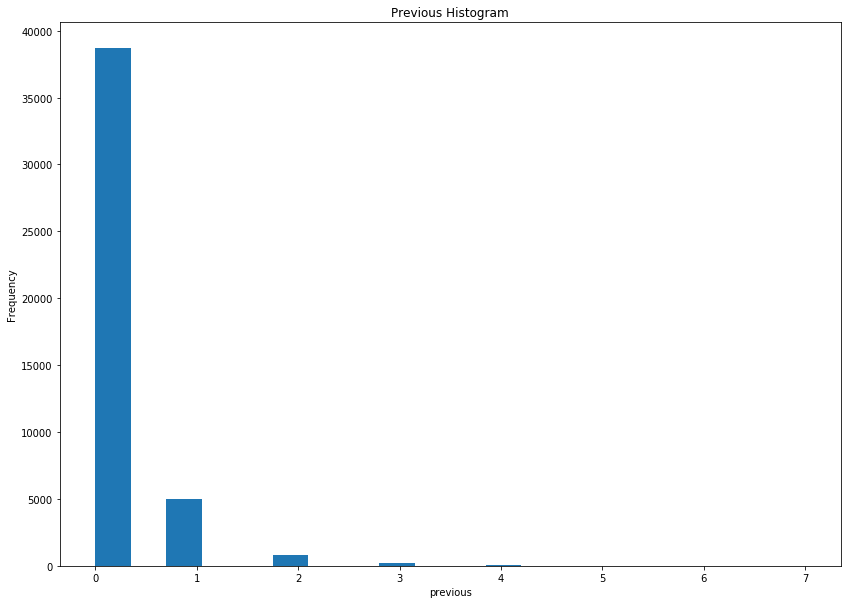

In [41]:
# previous: number of contacts performed before this campaign and for this client (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['previous'],bins=20)
plt.title("Previous Histogram")
plt.xlabel("previous")
plt.ylabel("Frequency")
plt.savefig('Previous histogram')

In [42]:
#group previous into three categories: 0-1 less, 2-5 medium, 6-7 more
bins = [0, 1, 5, 7]
labels = ['less', 'medium', 'more']
data['previousrange'] = pd.cut(data.previous, bins, labels = labels,include_lowest = True)

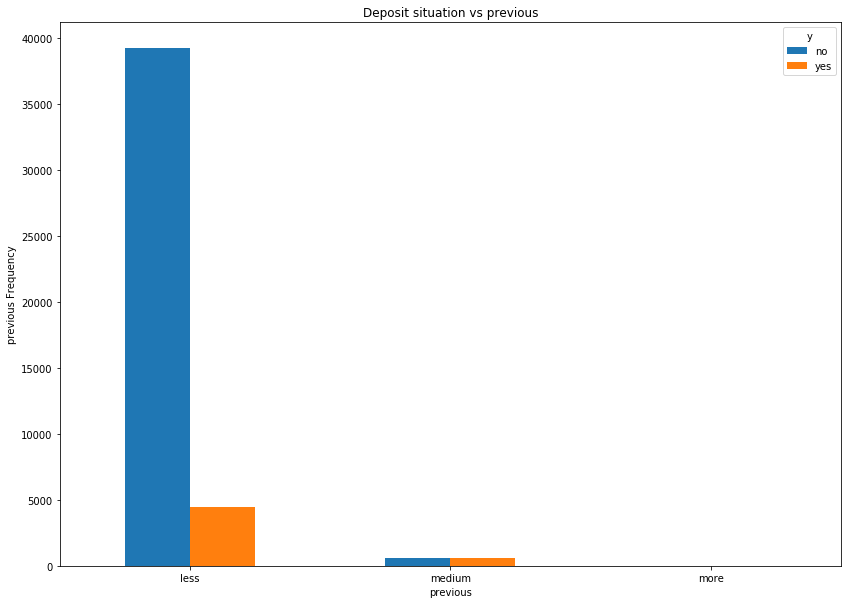

In [43]:
pd.crosstab(data.previousrange,data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs previous')
plt.xlabel('previous')
plt.xticks(rotation = 0)
plt.ylabel('previous Frequency')
plt.savefig('Deposit_previous')

### It shows that the more previous contact, more people made deposits.

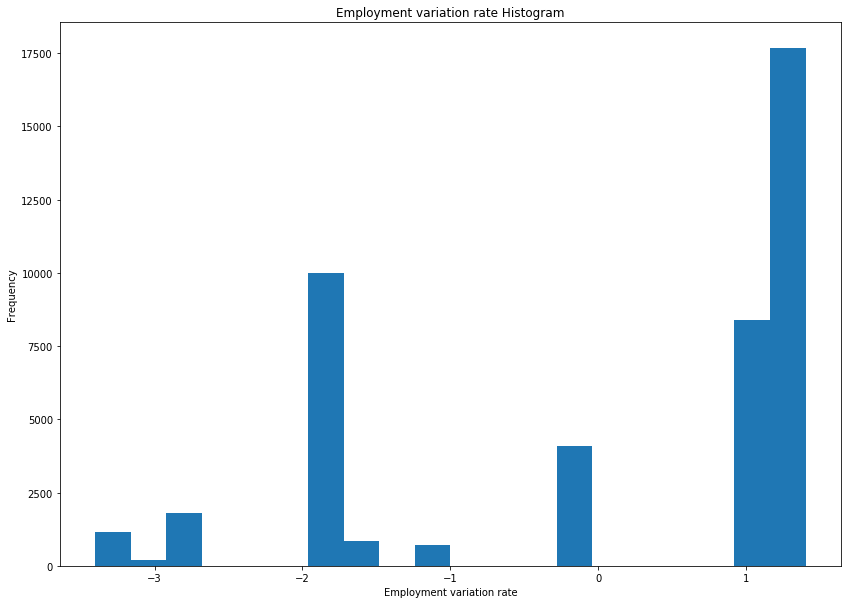

In [44]:
# emp.var.rate: employment variation rate - quarterly indicator (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['emp.var.rate'],bins=20)
plt.title("Employment variation rate Histogram")
plt.xlabel("Employment variation rate")
plt.ylabel("Frequency")
plt.savefig('Employment variation rate histogram')

In [45]:
#group emp.var.rate into three categories: -3.40--2 small, -2-0 medium, 0-1.4 large
bins = [-3.40, -2, 0, 1.4]
labels = ['small', 'medium', 'large']
data['emp.var.raterange'] = pd.cut(data['emp.var.rate'], bins, labels = labels,include_lowest = True)

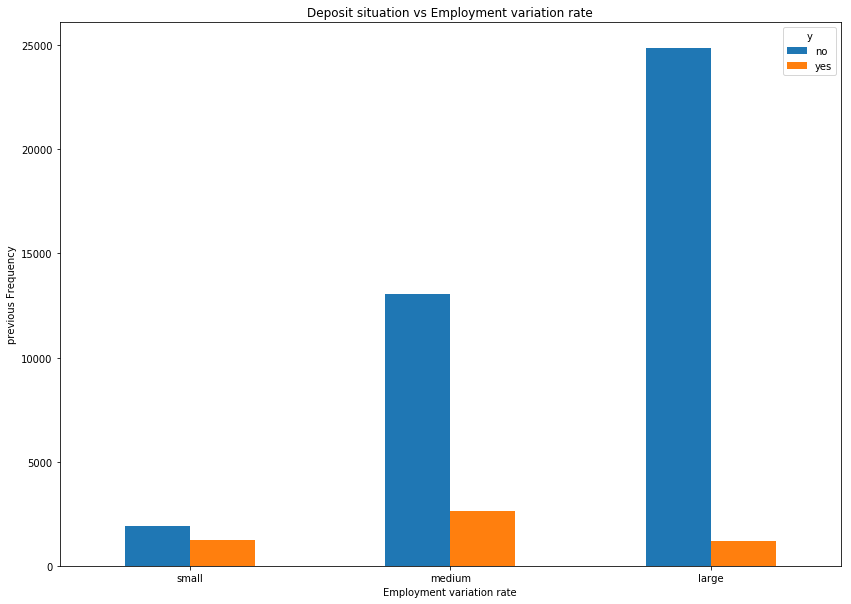

In [46]:
pd.crosstab(data['emp.var.raterange'],data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs Employment variation rate')
plt.xlabel('Employment variation rate')
plt.xticks(rotation = 0)
plt.ylabel('previous Frequency')
plt.savefig('Deposit_Employment variation rate')

### It is clear that increase of employment variation rate leads to less people making deposits.

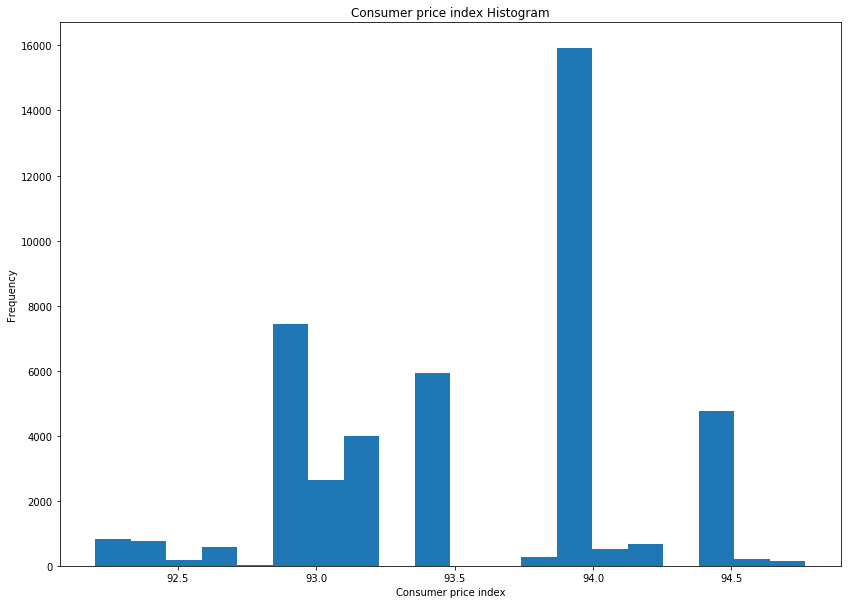

In [47]:
# cons.price.idx: consumer price index - monthly indicator (numeric) 
fig = plt.figure(figsize=(14, 10))
plt.hist(data['cons.price.idx'],bins=20)
plt.title("Consumer price index Histogram")
plt.xlabel("Consumer price index")
plt.ylabel("Frequency")
plt.savefig('Consumer price index histogram')

In [48]:
#group cons.price.idx into three categories: 92.2-93 small, 93-94 medium, 94-94.5 large
bins = [92.2, 93, 94, 94.5]
labels = ['small', 'medium', 'large']
data['cons.price.idxrange'] = pd.cut(data['cons.price.idx'], bins, labels = labels,include_lowest = True)

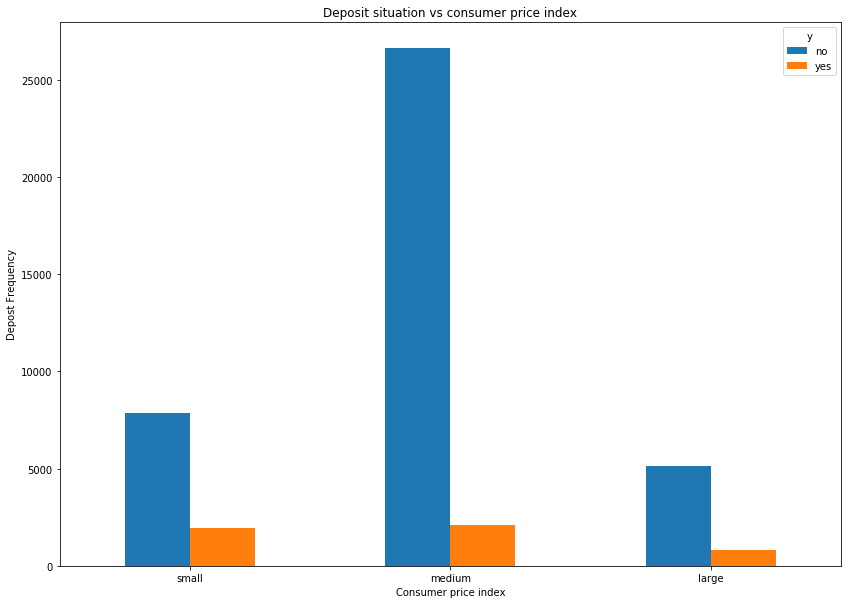

In [49]:
pd.crosstab(data['cons.price.idxrange'],data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs consumer price index')
plt.xlabel('Consumer price index')
plt.xticks(rotation = 0)
plt.ylabel('Depost Frequency')
plt.savefig('Deposit_consumer price index')

### The relationship between deposits and consumer price index is not apparrent.

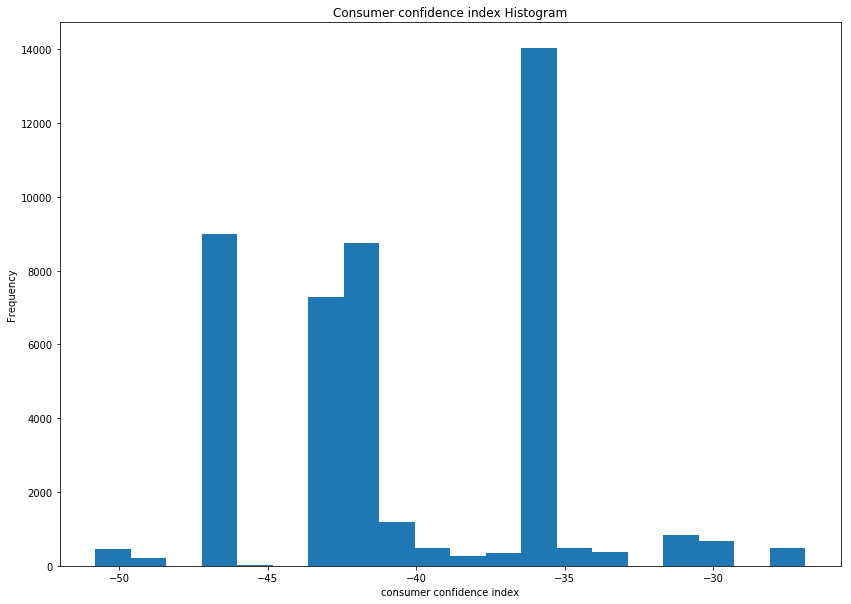

In [50]:
#  cons.conf.idx: consumer confidence index - monthly indicator (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['cons.conf.idx'],bins=20)
plt.title("Consumer confidence index Histogram")
plt.xlabel("consumer confidence index")
plt.ylabel("Frequency")
plt.savefig('consumer confidence index histogram')

In [51]:
#group cons.conf.idx into three categories: -50.8--45 small, -45--35 medium, -35--30 large
bins = [-50.8, -45, -35, -30]
labels = ['small', 'medium', 'large']
data['cons.conf.idxrange'] = pd.cut(data['cons.conf.idx'], bins, labels = labels,include_lowest = True)

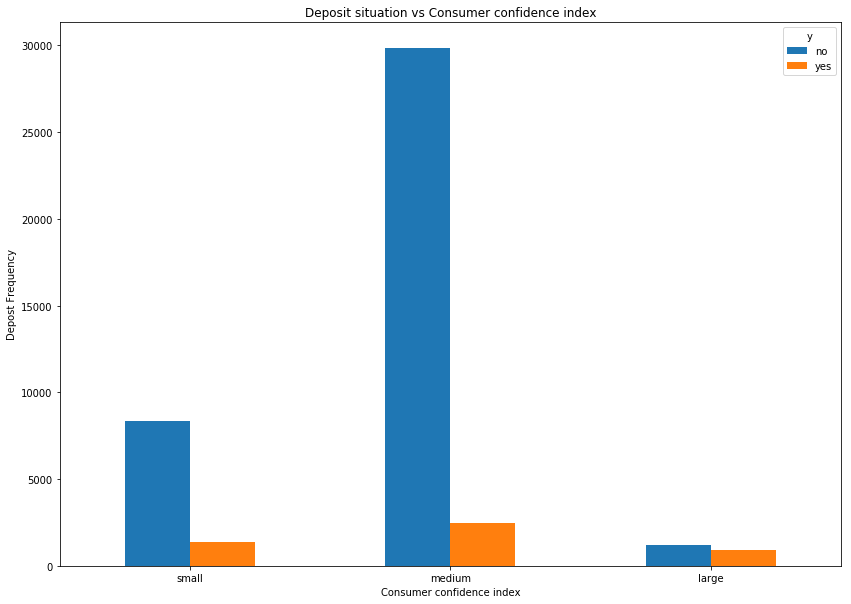

In [52]:
pd.crosstab(data['cons.conf.idxrange'],data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs Consumer confidence index')
plt.xlabel('Consumer confidence index')
plt.xticks(rotation = 0)
plt.ylabel('Depost Frequency')
plt.savefig('Deposit_Consumer confidence index')

### It seems that the larger the consumer confidence index, more people made deposits.

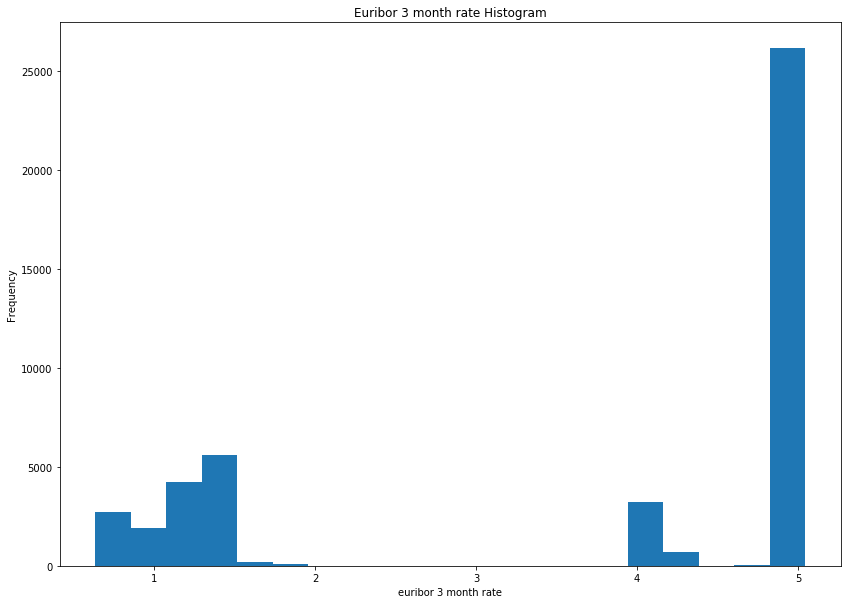

In [53]:
# euribor3m: euribor 3 month rate - daily indicator (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['euribor3m'],bins=20)
plt.title("Euribor 3 month rate Histogram")
plt.xlabel("euribor 3 month rate")
plt.ylabel("Frequency")
plt.savefig('euribor 3 month rate histogram')

In [54]:
#group euribor3m into three categories: 0.63-2 small, 2-4 medium, 4-5.05 large
bins = [0.63,2,4,5.05]
labels = ['small', 'medium', 'large']
data['euribor3mrange'] = pd.cut(data['euribor3m'], bins, labels = labels,include_lowest = True)

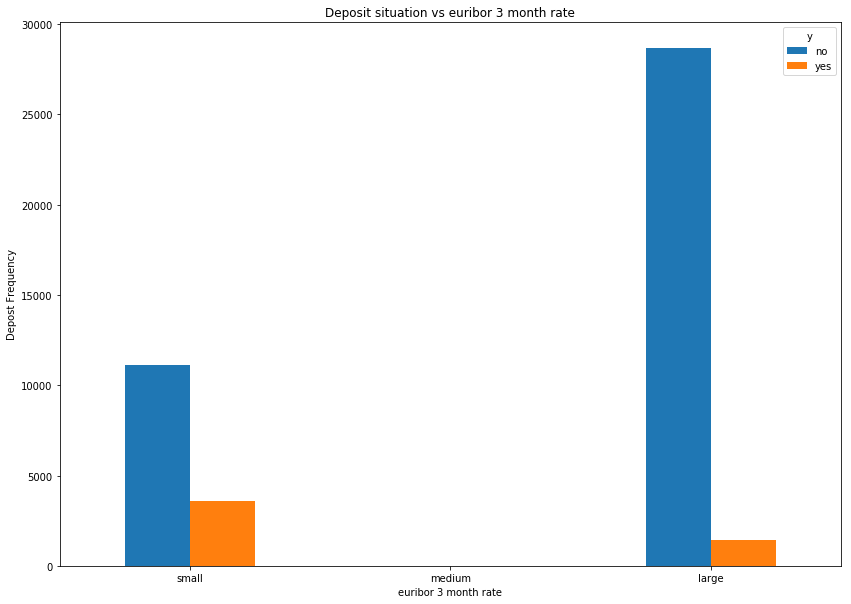

In [55]:
pd.crosstab(data['euribor3mrange'],data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs euribor 3 month rate')
plt.xlabel('euribor 3 month rate')
plt.xticks(rotation = 0)
plt.ylabel('Depost Frequency')
plt.savefig('Deposit_euribor 3 month rate')

### It is obvious that larger of euribor 3 month rate, less people made deposits.

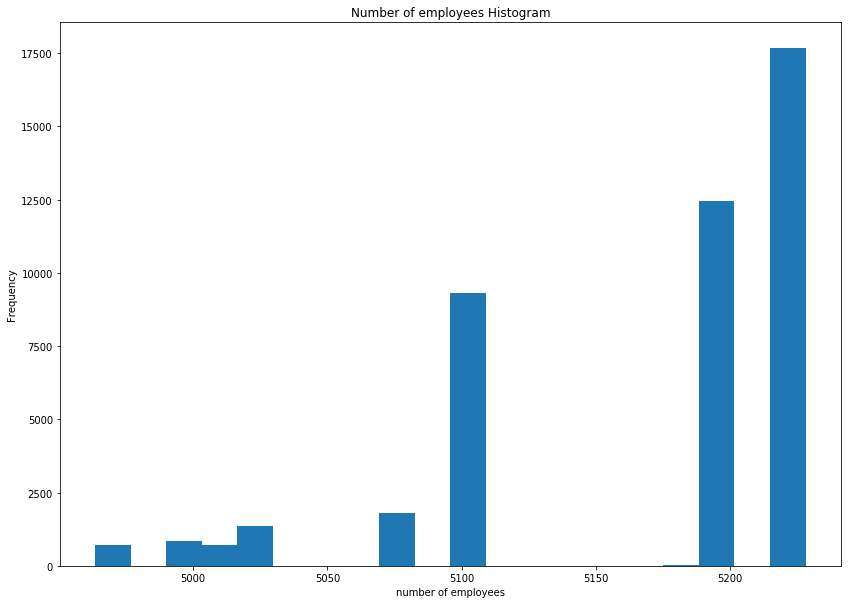

In [56]:
#  nr.employed: number of employees - quarterly indicator (numeric)
fig = plt.figure(figsize=(14, 10))
plt.hist(data['nr.employed'],bins=20)
plt.title("Number of employees Histogram")
plt.xlabel("number of employees")
plt.ylabel("Frequency")
plt.savefig('Number of employees histogram')

In [57]:
# group nr.employed into three categories: 4963-5050 small, 5050-5200 medium, 5200-5228 large
bins = [4960,5050,5200,5229]
labels = ['small', 'medium', 'large']
data['nr.employedrange'] = pd.cut(data['nr.employed'], bins, labels = labels,include_lowest = True)

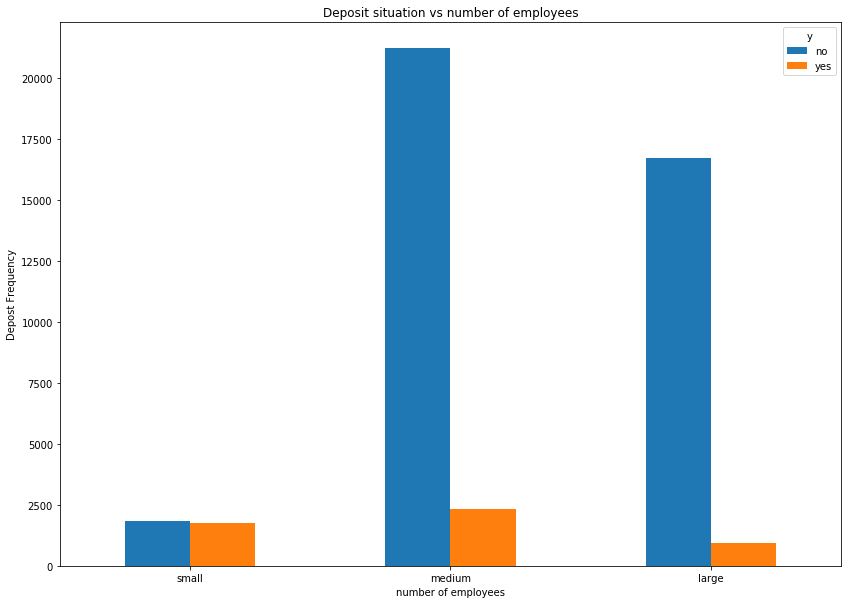

In [58]:
pd.crosstab(data['nr.employedrange'],data.y).plot(kind='bar',figsize=(14, 10))
plt.title('Deposit situation vs number of employees')
plt.xlabel('number of employees')
plt.xticks(rotation = 0)
plt.ylabel('Depost Frequency')
plt.savefig('Deposit_number of employees')

### It is apparrent that larger the number of employed, the less people made deposits.

                     age  duration  campaign     pdays  previous  \
age             1.000000  0.001465  0.005735 -0.028799  0.017334   
duration        0.001465  1.000000 -0.073045 -0.045765  0.017407   
campaign        0.005735 -0.073045  1.000000  0.048044 -0.075887   
pdays          -0.028799 -0.045765  0.048044  1.000000 -0.572767   
previous        0.017334  0.017407 -0.075887 -0.572767  1.000000   
emp.var.rate    0.023106 -0.024888  0.143633  0.261800 -0.428870   
cons.price.idx  0.019097  0.006540  0.127220  0.088372 -0.237600   
cons.conf.idx   0.114625 -0.011398  0.000840 -0.103338 -0.053882   
euribor3m       0.029222 -0.029111  0.127419  0.284417 -0.454898   
nr.employed     0.006085 -0.040427  0.135711  0.356916 -0.496988   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                 0.023106        0.019097       0.114625   0.029222   
duration           -0.024888        0.006540      -0.011398  -0.029111   
campaign            0.143633 

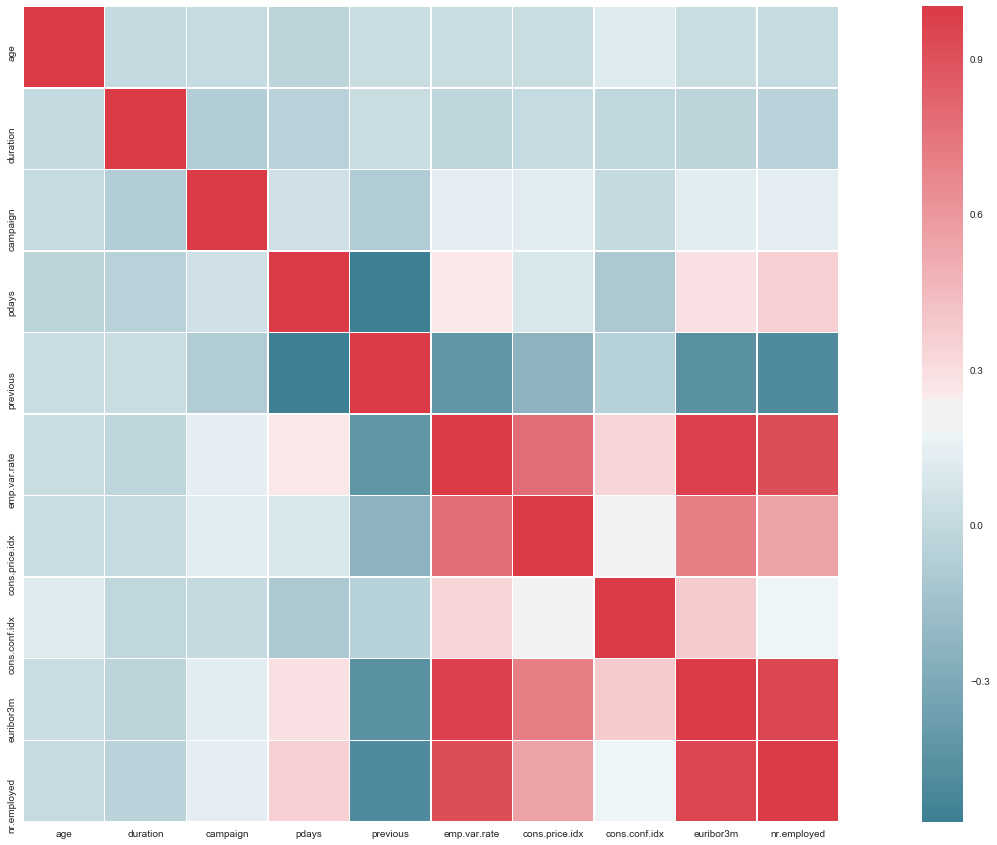

In [59]:
#following are calculations for correlation matrix between all vaiables of dataset data
#print(final_data.columns)
#Corelation Matrix
sns.set(style="white")
df_corr = data[:]

# Compute the correlation matrix
corr = df_corr.dropna().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(30, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, ax=ax)

print(corr)

### We see that there is strong negative correlation between Pdays and previous (-0.572977), more times of previous contacts, less the pdays to make deposits. Another pair is number of employed and euribor3m and they have strong positively correlated (0.949020). euribor3m correlates with employment variation rate at 0.975248.

In [60]:
data_dmy = pd.get_dummies(data, columns =['job', 'marital', 'education','default', 'housing', 'loan','contact','month', 'day_of_week','poutcome'],drop_first=True)

In [61]:
data_dmy.loc[data_dmy.y == 'yes','y'] = 1
data_dmy.loc[data_dmy.y == 'no','y'] = 0

In [62]:
data_vars=data_dmy.columns.values.tolist()

In [63]:
removal_vars = ['agerange', 'durationrange', 'campaignrange', 'pdaysrange', 'previousrange', 'emp.var.raterange', 'cons.price.idxrange', 'cons.conf.idxrange', 'euribor3mrange', 'nr.employedrange']
keep=[i for i in data_vars if i not in removal_vars]
final_data = data_dmy[keep]
final_data.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_married', 'marital_single', 'education_basic.6y',
       'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown',
       'default_unknown', 'default_yes', 'housing_unknown', 'housing_yes',
       'loan_unknown', 'loan_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success'], dtype=object

In [64]:
final_data_vars = final_data.columns.values.tolist()

y = ['y']
X = [i for i in final_data_vars if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(final_data[X], final_data[y] )
print(rfe.support_)

C:\Users\VT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False False  True False False False  True False  True  True
 False False  True False  True  True False False False False False False
 False False False False False  True False False False False False  True
 False  True  True  True  True  True False  True False  True False False
 False  True  True]


### Through RFE processing, it is feasible to choose variables whose bool values are True. 

In [65]:
cols=["previous", "euribor3m", "job_blue-collar", "job_entrepreneur", "job_retired", "job_services", 
      "job_student", "default_unknown",  "contact_telephone","month_dec", "month_jul", "month_jun", "month_mar", "month_may",
       "month_oct", "day_of_week_mon","poutcome_nonexistent","poutcome_success"] 
X = final_data[cols]
y = final_data['y']

## Logistic Regression:

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

LogReg = LogisticRegression(fit_intercept = False, C = 1e12,random_state=0)

LogReg.fit(X_train.astype(float), y_train.astype(float))
score = LogReg.score(X_train.astype(float), y_train.astype(float))
print('Accuracy of logistic regression classifier on training set: {:.2f}\n'.format(score))

y_pred = LogReg.predict(X_test)
print('Accuracy of logistic regression classifier on testing set: {:.2f}'.format(LogReg.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.90

Accuracy of logistic regression classifier on testing set: 0.90


In [67]:
logit_model = sm.Logit(y_train.astype(float),X_train.astype(float))
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.282299
         Iterations 7
                           Results: Logit
Model:                Logit             No. Iterations:    7.0000    
Dependent Variable:   y                 Pseudo R-squared:  0.196     
Date:                 2018-06-03 20:28  AIC:               22828.7979
No. Observations:     40370             BIC:               22983.7030
Df Model:             17                Log-Likelihood:    -11396.   
Df Residuals:         40352             LL-Null:           -14168.   
Converged:            1.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
previous             -0.2561   0.0326  -7.8623 0.0000 -0.3199 -0.1923
euribor3m            -0.5356   0.0123 -43.4720 0.0000 -0.5598 -0.5115
job_blue-collar 

### The 18 variables are all siginificantly contribued to the overall logistic model since all p values are less than 0.05 

In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('The confusion matrix is :\n',confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

The confusion matrix is :
 [[3939   34]
 [ 420   93]]
             precision    recall  f1-score   support

          0       0.90      0.99      0.95      3973
          1       0.73      0.18      0.29       513

avg / total       0.88      0.90      0.87      4486



### The confusion matrix tells us that the 3939/(3939 + 420) = 0.904  and specificity = 93/(34 + 93) = 0.732

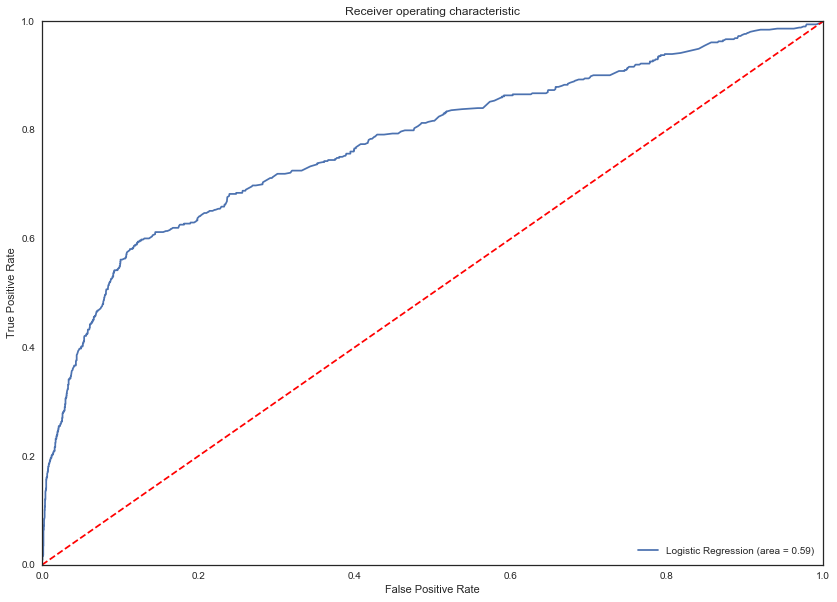

In [69]:
logit_roc_auc = roc_auc_score(y_test, LogReg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LogReg.predict_proba(X_test)[:,1])
fig = plt.figure(figsize=(14, 10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

## Random Forest 